<b><font size=5><center>Исследование поведения пользователей мобильного приложения.</b>

# Описание проекта

Cтартап, который продаёт продукты питания, нуждается в анализе поведения пользователей мобильного приложения.
Требуется узнать сколько пользователей доходит до покупки, а сколько — «застревает» на предыдущих шагах. На основе результатов A/A/B-эксперимента выяснить повлияло ли на пользователей изменение шрифта во всём приложении. 

*Описание данных*

Каждая запись в логе — это действие пользователя, или событие.

`EventName` — название события;

`DeviceIDHash` — уникальный идентификатор пользователя;

`EventTimestamp` — время события;

`ExpId` — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная.

# Шаг 1. Загрузка данных

In [1]:
#подключим необходимые для работы библиотеки
import pandas as pd
from scipy import stats as st
import numpy as np
import math as mth
import datetime as dt
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
pd.options.display.max_colwidth = 150
pd.set_option('chained_assignment', None) 

In [2]:
#откроем датафрейм

data = pd.read_csv('/datasets/logs_exp.csv', sep='\t')
    
display(data.head())
data.info()

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


# Шаг 2. Подготовка данных

In [3]:
# Заменим названия столбцов
data = data.rename(columns={'EventName':'event_name', 'DeviceIDHash':'device_id_hash', 'EventTimestamp':'event_timestamp', 'ExpId':'exp_id'})
data.columns

Index(['event_name', 'device_id_hash', 'event_timestamp', 'exp_id'], dtype='object')

In [4]:
# Проверим пропуски
data.isna().sum()

event_name         0
device_id_hash     0
event_timestamp    0
exp_id             0
dtype: int64

In [5]:
# Проверим наличие строк-дубликов
print('Количество дубликатов до:', data.duplicated().sum())

Количество дубликатов до: 413


In [6]:
# Удалим строки-дубликаты
data = data.drop_duplicates().reset_index(drop=True)
print('Количество дубликатов после:', data.duplicated().sum())

Количество дубликатов после: 0


In [7]:
# Добавим столбец даты и времени, а также отдельный столбец дат
data['date_time'] = pd.to_datetime(data['event_timestamp'], unit='s')
data['date'] = data['date_time'].dt.date
display(data.head())
data.info()

,event_name,device_id_hash,event_timestamp,exp_id,date_time,date
0,MainScreenAppear,4575588528974610257,1564029816,246,2019-07-25 04:43:36,2019-07-25
1,MainScreenAppear,7416695313311560658,1564053102,246,2019-07-25 11:11:42,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
3,CartScreenAppear,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248,2019-07-25 11:48:42,2019-07-25


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243713 entries, 0 to 243712
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   event_name       243713 non-null  object        
 1   device_id_hash   243713 non-null  int64         
 2   event_timestamp  243713 non-null  int64         
 3   exp_id           243713 non-null  int64         
 4   date_time        243713 non-null  datetime64[ns]
 5   date             243713 non-null  object        
dtypes: datetime64[ns](1), int64(3), object(2)
memory usage: 11.2+ MB


# Шаг 3. Проверка данных

In [8]:
# Узнаем сколько в среднем событий приходится на пользователя
event_sum = len(data['event_name'])
users = data['device_id_hash'].nunique()
event_per_user = event_sum / users
print(f'Всего в логе {event_sum} событий')
print(f'Всего в логе {users} пользователей')
print(f'В среднем на одного пользователя приходится {event_per_user} события')

Всего в логе 243713 событий
Всего в логе 7551 пользователей
В среднем на одного пользователя приходится 32.27559263673685 события


In [9]:
# Узнаем за какой период данные
date_min = data['date'].min()
data_max = data['date'].max()
period = data_max - date_min
print('Период исследования:', period)
print('Минимальная дата:', date_min)
print('Максимльная дата:', data_max)


Период исследования: 13 days, 0:00:00
Минимальная дата: 2019-07-25
Максимльная дата: 2019-08-07


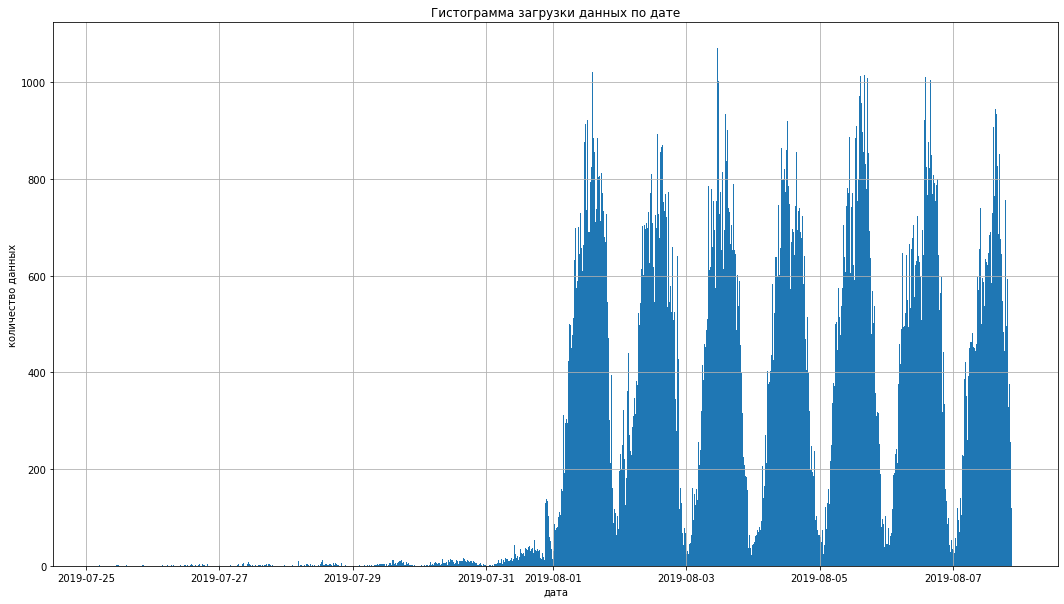

In [10]:
# Построим гистограмму по дате
plt.figure(figsize=(18,10))
data['date_time'].hist(bins=1000)
plt.xlabel('дата') 
plt.ylabel('количество данных')
plt.title('Гистограмма загрузки данных по дате')  

plt.show()

**Данные, судя по графику, не одинаково полные за весь период. Начиная с 2019-08-01 данные можно считать полными.**

In [11]:
# Отфильтруем старые данные
new_data = data.query('date_time >= "2019-08-01"')
old_data = data.query('date_time < "2019-08-01"')
event_old = old_data['event_name'].size
event_old_percent = (event_old / len(data['event_name'])*100)
users_new = new_data['device_id_hash'].nunique()
users_old = users - users_new
users_old_percent =(users_old / users *100)
print(f'В результате фильтрации было удалено {event_old_percent} % событий,')
print(f'а также {users_old_percent} % уникальных пользователей')

В результате фильтрации было удалено 1.159560630741897 % событий,
а также 0.22513574361011784 % уникальных пользователей


In [12]:
# Узнаем какой период охватывают новые данные
new_date_min = new_data['date'].min()
data_max = data['date'].max()
period = data_max - new_date_min
print('Период исследования:', period)
print('Минимальная дата:', new_date_min)
print('Максимльная дата:', data_max)

Период исследования: 6 days, 0:00:00
Минимальная дата: 2019-08-01
Максимльная дата: 2019-08-07


In [13]:
# Проверим, что в новых данных есть пользователи из всех трёх экспериментальных групп
new_data['exp_id'].value_counts()

248    84563
246    79302
247    77022
Name: exp_id, dtype: int64

# Шаг 4. Анализ воронки событий

In [14]:
# Посмотрим, какие события есть в логах, как часто они встречаются
new_data['event_name'].value_counts()

MainScreenAppear           117328
OffersScreenAppear          46333
CartScreenAppear            42303
PaymentScreenSuccessful     33918
Tutorial                     1005
Name: event_name, dtype: int64

In [15]:
# Посчитаем, сколько пользователей совершали каждое из этих событий
funnel = (
    new_data
    .groupby('event_name')
    .agg({'device_id_hash':'nunique'})
    .rename(columns={'device_id_hash':'unique users'})
    .reset_index()
    .query('event_name != "Tutorial"')
    .sort_values(by='unique users', ascending=False)
)
# Посчитаем долю пользователей, которые хоть раз совершали событие
funnel['conversion,%'] = round(100 * funnel['unique users'] / users_new, 2)
funnel

,event_name,unique users,"conversion,%"
1,MainScreenAppear,7419,98.47
2,OffersScreenAppear,4593,60.96
0,CartScreenAppear,3734,49.56
3,PaymentScreenSuccessful,3539,46.97


**Можно предположить, что события происходят в следующем порядке: MainScreenAppear->OffersScreenAppear->CartScreenAppear->PaymentScreenSuccessful. Событие Tutorial не выстраивается в последовательную цепочку, поэтому его можно учитывать при расчёте воронки.**

In [16]:
# Посчитаем какая доля пользователей проходит на следующий шаг воронки (от числа пользователей на предыдущем)
funnel['conversion_step,%'] = round(100 * funnel['unique users'] / funnel['unique users'].shift(1, fill_value=funnel['unique users'][1]),2)
funnel

,event_name,unique users,"conversion,%","conversion_step,%"
1,MainScreenAppear,7419,98.47,100.00
2,OffersScreenAppear,4593,60.96,61.91
0,CartScreenAppear,3734,49.56,81.30
3,PaymentScreenSuccessful,3539,46.97,94.78


In [ ]:
fig = px.funnel(funnel, x=funnel['conversion,%'], y=funnel['event_name'])

fig.show()

In [18]:
# Посчитаем какая доля пользователей проходит на следующий шаг воронки (от числа пользователей на предыдущем) в каждой группе
funnel_gr = (
    new_data
    .query('event_name != "Tutorial"')
    .pivot_table(index='event_name', columns='exp_id', values='device_id_hash', aggfunc='nunique')
    .sort_values(by=246, ascending=False)
)
funnel_gr['cnv_step_246,%'] = round(100 * funnel_gr[246] / funnel_gr[246].shift(1, fill_value=funnel_gr[246][0]),2)
funnel_gr['cnv_step_247,%'] = round(100 * funnel_gr[247] / funnel_gr[247].shift(1, fill_value=funnel_gr[247][0]),2)
funnel_gr['cnv_step_248,%'] = round(100 * funnel_gr[248] / funnel_gr[248].shift(1, fill_value=funnel_gr[248][0]),2)
funnel_gr


exp_id,246,247,248,"cnv_step_246,%","cnv_step_247,%","cnv_step_248,%"
event_name,,,,,,
MainScreenAppear,2450,2476,2493,100.00,100.00,100.00
OffersScreenAppear,1542,1520,1531,62.94,61.39,61.41
CartScreenAppear,1266,1238,1230,82.10,81.45,80.34
PaymentScreenSuccessful,1200,1158,1181,94.79,93.54,96.02


In [19]:
funnel_gr.index

Index(['MainScreenAppear', 'OffersScreenAppear', 'CartScreenAppear',
       'PaymentScreenSuccessful'],
      dtype='object', name='event_name')

**Согласно воронке событий больше всего пользователей теряется на событии OffersScreenAppear как в целом по данным, так и в каждой группе (от 37 % до 38,6 % пользователей теряются). В среднем по всем группам от от первого события до оплаты доходит 47,7 % пользователей.**


# Шаг 5. Анализ результатов эксперимента

In [20]:
# Узнаем сколько пользователей в каждой экспериментальной группе
trials = new_data.groupby('exp_id').agg({'device_id_hash':'nunique'})
trials

,device_id_hash
exp_id,
246,2484
247,2513
248,2537


**Проверим, находят ли статистические критерии разницу между выборками 246 и 247. Применим z-тест для пропорций.**

*Гипотезы для всех событий:*
- H0: доли пользователей, выполнивших событие в группах 246 и 247, равны
- H1: доли пользователей, выполнивших событиесобытие в группах 246 и 247, не равны

В качестве уровня стат значимости возьмем 0,01. Такой уровень снижает вероятность получить ложнопозитивный результат стат теста. Вместе с тем, если различие в выбоках действительно есть, то данный уровень не позволит сделать ее стат зачимой. 

In [21]:
# Напишем функцию для проверки гипотезы о равенстве долей
def get_p_value(success1, success2, trials1, trials2):
    p1 = success1 / trials1
    p2 = success2 / trials2
    p_combined = (success1 + success2) / (trials1 + trials2) 
    difference = p1 - p2 
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials1 + 1/trials2))
    distr = st.norm(0, 1)  
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    return p_value

# Проверим, находят ли статистические критерии разницу между выборками 246 и 247
for x in [[246, 247]]:
    for i in funnel_gr.index:
        p_value = get_p_value(funnel_gr.loc[i,x[0]], funnel_gr.loc[i,x[1]], trials.loc[x[0]].values[0], trials.loc[x[1]].values[0])
        print('p-значение для:',i,x,p_value)
        if p_value < 0.01: 
            print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
        else:
            print('Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными')

p-значение для: MainScreenAppear [246, 247] 0.7570597232046099
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение для: OffersScreenAppear [246, 247] 0.2480954578522181
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение для: CartScreenAppear [246, 247] 0.22883372237997213
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение для: PaymentScreenSuccessful [246, 247] 0.11456679313141849
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


**Результаты проведенного тестирования позволяют сделать вывод о равенстве долей пользователей в двух группах. Поскольку это контрольные группы и стат значимой разницы в них не должно быть, можно заключить, что разбиение на группы работает корректно.**

**Проверим, существует ли стат значимая разница между контрольными группами и группой с изменённым шрифтом.**

In [22]:
# Сравните результаты с каждой из контрольных групп в отдельности по каждому событию
for x in [[246, 248], [247, 248]]:
    for i in funnel_gr.index:
        p_value = get_p_value(funnel_gr.loc[i,x[0]], funnel_gr.loc[i,x[1]], trials.loc[x[0]].values[0], trials.loc[x[1]].values[0])
        print('p-значение для:',i,x,p_value)
        if p_value < 0.01: 
            print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
        else:
            print('Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными')

p-значение для: MainScreenAppear [246, 248] 0.2949721933554552
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение для: OffersScreenAppear [246, 248] 0.20836205402738917
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение для: CartScreenAppear [246, 248] 0.07842923237520116
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение для: PaymentScreenSuccessful [246, 248] 0.2122553275697796
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение для: MainScreenAppear [247, 248] 0.4587053616621515
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение для: OffersScreenAppear [247, 248] 0.9197817830592261
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение для: CartScreenAppear [247, 248] 0.5786197879539783
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


**Статистически значимых различий между тестируемой группой и контрольными нет. Следовательно изменение шрифта не повлияло на ковертируемость пользователей в покупателей.**

In [23]:
# Объединим контрольные группы в одну и проверим гипотезы о равенстве долей каждого события
combined = new_data.query('exp_id in [246, 247]')
combined['exp_id'] = '246 + 247'
combined_data= new_data.append(combined)
combined_data.head()
combined_data['exp_id'].unique()

array([246, 247, 248, '246 + 247'], dtype=object)

In [24]:
funnel_combined = (
    combined_data
    .query('event_name != "Tutorial"')
    .pivot_table(index='event_name', columns='exp_id', values='device_id_hash', aggfunc='nunique')
    .sort_values(by=246, ascending=False)
)
funnel_combined

exp_id,246,247,248,246 + 247
event_name,,,,
MainScreenAppear,2450,2476,2493,4926
OffersScreenAppear,1542,1520,1531,3062
CartScreenAppear,1266,1238,1230,2504
PaymentScreenSuccessful,1200,1158,1181,2358


In [25]:
trials_combined = combined_data.groupby('exp_id').agg({'device_id_hash':'nunique'})
trials_combined

,device_id_hash
exp_id,
246,2484
247,2513
248,2537
246 + 247,4997


In [26]:
for x in [['246 + 247', 248]]:
    for i in funnel_gr.index:
        p_value = get_p_value(funnel_combined.loc[i,x[0]], funnel_combined.loc[i,x[1]], trials_combined.loc[x[0]].values[0], trials_combined.loc[x[1]].values[0])
        print('p-значение для:',i,x,p_value)
        if p_value < 0.01: 
            print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
        else:
            print('Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными')

p-значение для: MainScreenAppear ['246 + 247', 248] 0.29424526837179577
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение для: OffersScreenAppear ['246 + 247', 248] 0.43425549655188256
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение для: CartScreenAppear ['246 + 247', 248] 0.18175875284404386
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение для: PaymentScreenSuccessful ['246 + 247', 248] 0.6004294282308704
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


**Статистически значимых различий между тестируемой группой и объединенными контрольными группами нет. Что еще раз подтверждает, что изменение шрифта не повлияло на ковертируемость пользователей в покупателей.**

*Было сделано 16 проверок статистических гипотез. Установим уровень стат значимости в 5% и посомтрим повлияло ли это на результаты.*

In [27]:
for x in [[246, 247], [246, 248], [247, 248]]:
    for i in funnel_gr.index:
        p_value = get_p_value(funnel_gr.loc[i,x[0]], funnel_gr.loc[i,x[1]], trials.loc[x[0]].values[0], trials.loc[x[1]].values[0])
        print('p-значение для:',i,x,p_value)
        if p_value < 0.05: 
            print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
        else:
            print('Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными')

p-значение для: MainScreenAppear [246, 247] 0.7570597232046099
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение для: OffersScreenAppear [246, 247] 0.2480954578522181
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение для: CartScreenAppear [246, 247] 0.22883372237997213
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение для: PaymentScreenSuccessful [246, 247] 0.11456679313141849
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение для: MainScreenAppear [246, 248] 0.2949721933554552
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение для: OffersScreenAppear [246, 248] 0.20836205402738917
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение для: CartScreenAppear [246, 248] 0.07842923237520116
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разным

In [28]:
for x in [['246 + 247', 248]]:
    for i in funnel_gr.index:
        p_value = get_p_value(funnel_combined.loc[i,x[0]], funnel_combined.loc[i,x[1]], trials_combined.loc[x[0]].values[0], trials_combined.loc[x[1]].values[0])
        print('p-значение для:',i,x,p_value)
        if p_value < 0.05: 
            print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
        else:
            print('Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными')

p-значение для: MainScreenAppear ['246 + 247', 248] 0.29424526837179577
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение для: OffersScreenAppear ['246 + 247', 248] 0.43425549655188256
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение для: CartScreenAppear ['246 + 247', 248] 0.18175875284404386
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение для: PaymentScreenSuccessful ['246 + 247', 248] 0.6004294282308704
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


**Результаты теста не повлияли на выводы. Статистически значимой разницы в группах нет**

# Общий вывод

В результате исследования было установлено:
- в среднем на одного пользователя приходится 32 события;
- тестирование длилось 6 дней в период с 2019-08-01 по 2019-08-07;
- событие Tutorial не встраивается в последовательную цепочку конвертации пользователей в покупатели;
- наибольшее число пользователей (от 37 % до 38,6 % ) теряется на событии OffersScreenAppear как в целом по данным, так и в каждой группе наблюжения;
- от первого события до оплаты доходит 47,7 % пользователей.

Результат А/А-теста установил отстутвие статистически значимой разницы между двумя контрольными группами, что свидельствует о верной разбивке на группы. Результат А/В-теста показал, что ковертируемость пользователей осталась преждней, то есть опасения менеджеров, что пользователям будет непривычно, не подтвердились. Вместе с тем новый шрифт нельзя считать лучше, поскольку он не принес большей конвертируемости.

Таким образом новый дизайн мобильного приложения не оказал на пользователей никакого влияния. 